In [5]:
import os
import sys
import pickle
import warnings 

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from utils import gen_clustering_metadata, extract_clustering_results, do_poisson_clustering,\
      do_poisson_clustering_improved, two_sample_test, nice_string_output, add_text_to_ax
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

#### TODO:
0) Lav noget cleanup af funktioner (indbyg mean i extract og væk med std for cluster size etc)
01) Måske er et hist af Nfraction og clustersize med sammenligning og kolmogrov et renere resultat
1) Gør stat.-analysen præsenterbar
2) Indsæt .225 when done
3) Overvej Nmin. Er 3 OK?
4) Prøv at smide noise ind på N i Poisson og se forskel(eller initaliser præcist ud fra N i hvert frame)
5) Efter proof of concept, byg det ind i infrastrukturen og lav analysen på tværs af L

In [2]:
base_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na512'
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = 512, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = 512, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]

Nexp_l, act_l, act_dir_l = gen_clustering_metadata(d_cluster_l['path'])
Nframes_l = 400
Nexp_vl, act_vl, act_dir_vl = gen_clustering_metadata(d_cluster_vl['path'])
Nframes_vl = 1500

In [3]:
Ncmin = 3
min_act_idx_l = 1 # we dont include 19 for convenience and lack of defects

cl_arr_l, cl_mean_l, cl_std_l = extract_clustering_results(Nframes_l, act_l, act_dir_l, len(Nexp_l), Ncmin=Ncmin, save=False)
cl_arr_vl, cl_mean_vl, cl_std_vl = extract_clustering_results(Nframes_vl, act_vl, act_dir_vl, len(Nexp_vl), Ncmin=Ncmin, save=False)

frame_idx_cutoff = Nframes_l
cl_arr_vl = cl_arr_vl[-frame_idx_cutoff:]
Nframes_vl = frame_idx_cutoff

cl_mean = np.concatenate([cl_mean_vl, cl_mean_l[:,min_act_idx_l:]], axis=1)
cl_std = np.concatenate([cl_std_vl, cl_std_l[:,min_act_idx_l:]], axis=1)

act_list = np.unique(np.concatenate([act_vl, act_l[min_act_idx_l:]]))

Below, Poisson simulation is done whilst allowing Ndef to vary for each activity, and also allowing for doing a greater number of Poisson simulation that we have defects frames.

In [4]:
L = 512
Rmax = 33
Ntrial = Nframes_l * len(Nexp_l)

method_kwargs = dict(n_clusters=None, linkage = 'single', distance_threshold=Rmax)

def_arr = np.concatenate([cl_arr_vl[-Nframes_l:, 0, :, :], cl_arr_l[:, 0, min_act_idx_l:, :]], axis=1)
def_arr_reshaped = def_arr.transpose(0,2,1).reshape(def_arr.shape[0] * def_arr.shape[-1], def_arr.shape[1])

cl_arr_uni , cl_mean_uni, cl_std_uni = do_poisson_clustering_improved(def_arr_reshaped, L, Ntrial=Ntrial, Ncmin = Ncmin, method_kwargs = method_kwargs)

In [ ]:
# Get some stats

for i, act in enumerate(act_list):
    print('Activity: {}'.format(act))
    z_nc,pval_nc = two_sample_test(cl_mean[1,i], cl_mean_uni[1,i], cl_std[1,i], cl_std_uni[1,i], small_statistics = False, one_sided=True)
    z_cs,pval_cs = two_sample_test(cl_mean[-1,i], cl_mean_uni[-1,i], cl_std[-1,i], cl_std_uni[-1,i], small_statistics = False, one_sided=True)
    print("z,p for Nclustered the same (one-sided): ", z_nc, pval_nc)
    print("z,p for cluster size the same (one-sided): ", z_cs, pval_cs)


42.15291174834145 6.5 -2.203047171177098
[  3.0500909    6.39080174  10.67038374   9.10947604 -24.00293986
 -31.48252801 -23.57487659 -23.42451972 -28.63061358]
[ 2.11570403  2.6308433   3.29075698  3.05006424 -2.0558868  -3.20924302
 -1.98987923 -1.96669413 -2.76947639]
3.2907569799404786 -3.209243020059521
[ 0.09688202  0.20299519  0.33893033  0.28935021 -0.76242098 -1.
 -0.74882413 -0.74404825 -0.90941279]
[-2.10616515 -2.00005198 -1.86411684 -1.91369696 -2.96546815 -3.20304717
 -2.9518713  -2.94709542 -3.11245996]


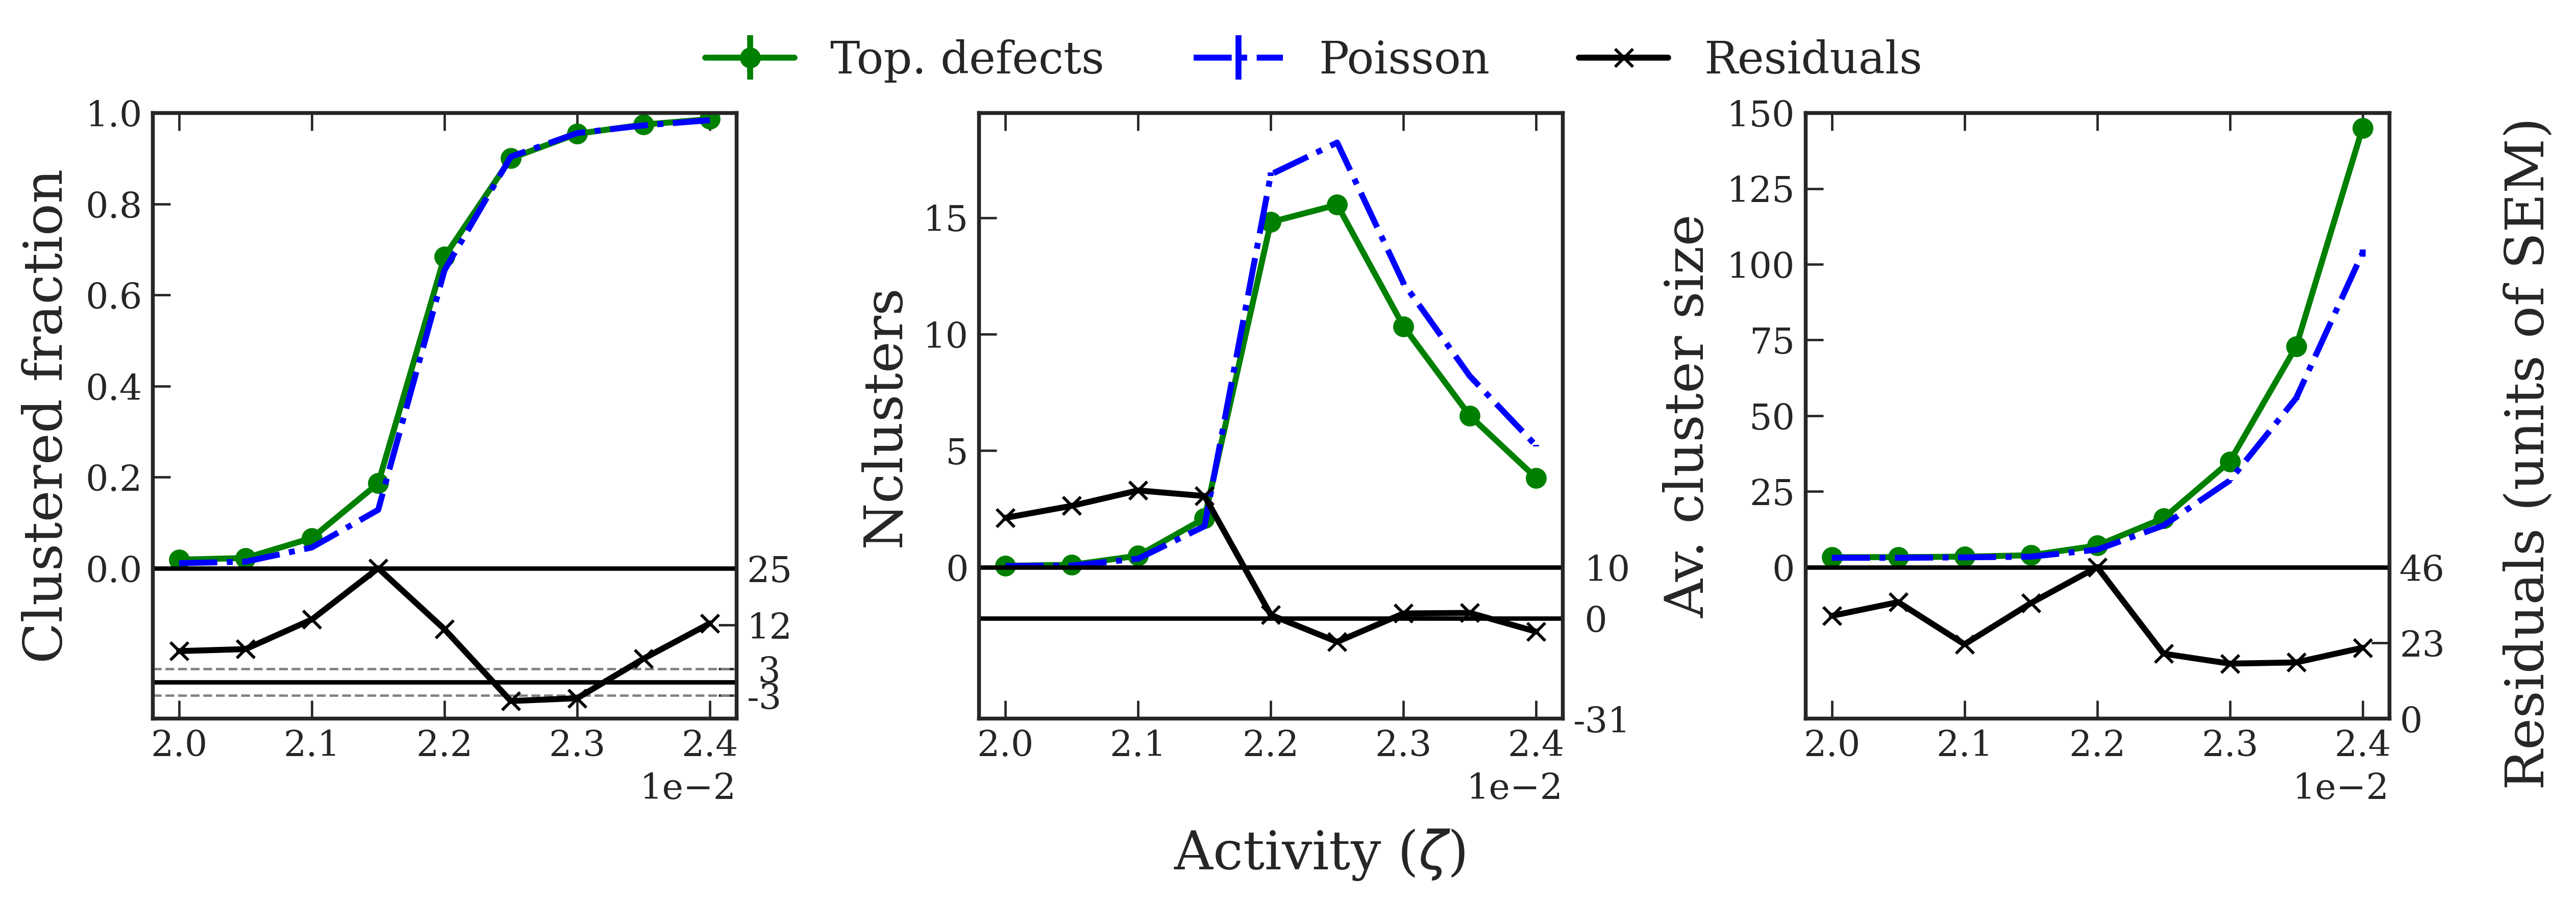

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4)) 

min_act_idx = 1

X = act_list[min_act_idx:]
Y = cl_mean[1:4, min_act_idx:]
dY = cl_std[1:4, min_act_idx:]
Y_uni = cl_mean_uni[1:4, min_act_idx:]
dY_uni = cl_std_uni[1:4, min_act_idx:]

Ydif = Y - Y_uni
Ydif_err = np.sqrt(dY**2 + dY_uni**2)
res_arr = Ydif / Ydif_err

for i in range(3):

    if i == 0:
        ax[i].set_ylim(0, 1)    
        kwargs_dict = dict(label = 'Top. defects')
        kwargs_dict_uni = dict(label = 'Poisson')
    else:
        kwargs_dict = dict()
        kwargs_dict_uni = dict()

    ax[i].errorbar(X, Y[i], yerr=dY[i], fmt='-o', color = 'green', **kwargs_dict)
    ax[i].errorbar(X, Y_uni[i], yerr=dY_uni[i], fmt='-.', color = 'blue', **kwargs_dict_uni)


    ax[i].set_ylabel(['Clustered fraction','Nclusters', 'Av. cluster size'][i])
    # set activity limits
    axinn_xlims = [1.98e-2, 2.42e-2]
    axinn_xticks = np.linspace(axinn_xlims[0]+2e-4, axinn_xlims[1] - 2e-4,5)
    ax[i].set(xticks=axinn_xticks, xlim=axinn_xlims)
    
    axx0 = ax[i].twinx()
    res_norm = res_arr[i]
    res_max = np.nanmax(np.abs(res_norm))


    if i == 0:
        bottom = -.33
        res_zero = -.25
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + res_zero)
        show_std_lines_for = 3

        ax[i].set_ylim(bottom, 1)
        ax[i].set(yticks=np.linspace(0,1,6), yticklabels=np.round(np.linspace(0,1, 6),1))
        
        # normalize res_norm by biggest value
        res_norm_unit = shift * res_norm / np.nanmax(np.abs(res_norm)) + res_zero

        axx0.set_yticks([res_zero - shift * show_std_lines_for/res_max, res_zero + shift * show_std_lines_for/res_max, res_zero + shift/2, top],\
                         [-show_std_lines_for,f' {show_std_lines_for}', int(np.max(res_norm) / 2), int(np.max(res_norm))])
        axx0.set_ylim((bottom, 1))

        axx0.axhline(y=0, color='black', linewidth=1.5)
        axx0.axhline(y=res_zero, color='black', linewidth=1.5)
        axx0.axhline(y=res_zero - shift * show_std_lines_for/res_max, color='grey', lw=.8, linestyle='--')
        axx0.axhline(y=res_zero + shift * show_std_lines_for/res_max, color='grey', lw=.8, linestyle='--')
        axx0.plot(act_list[min_act_idx:], res_norm_unit, 'kx-', label='Residuals')

    if i == 1:
        ax[i].set(yticks=np.linspace(0,15,4), yticklabels=np.linspace(0,15,4).astype('int'))

        res_max_signed = np.nanmax(res_norm)
        res_min_signed = np.nanmin(res_norm) 

        res_range = np.abs(res_max_signed - res_min_signed)
  
        bottom = -6.5
        res_zero = min(res_max_signed, -res_min_signed) / max(res_max_signed, -res_min_signed) * bottom
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + bottom) 
        show_std_lines_for = 3

        ax[i].set_ylim(bottom, - 3*bottom)

        res_max_signed = np.nanmax(res_norm)
        res_min_signed = np.nanmin(res_norm)    

        # normalize res_norm by biggest value
        res_norm_unit = (np.abs(bottom) - np.abs(res_zero)) *  res_norm / res_max - np.abs(res_zero)
        res_norm_unit = res_norm * (shift / res_range) #+ res_zero
        res_norm_unit += np.max(res_norm_unit)
        print(res_range, shift, res_zero)
        print(res_norm)
        print(res_norm_unit)
        print(np.max(res_norm_unit), np.min(res_norm_unit   ))
        print(res_norm / res_max)
        print(res_norm / res_max - np.abs(res_zero))

        axx0.set_yticks([bottom, res_zero, top],\
                         [f'{int(res_min_signed)}', ' 0', f' {int(res_max_signed)}'])
        axx0.set_ylim((bottom, -3*bottom))
        axx0.axhline(y=0, color='black', linewidth=1.5)
        axx0.axhline(y=res_zero, color='black', linewidth=1.5)
        axx0.plot(act_list[min_act_idx:], res_norm_unit, 'kx-',) #label='Residuals')

    if i == 2:

        ax[i].set(yticks=np.linspace(0,150,7), yticklabels=np.linspace(0,150,7).astype('int'))

        bottom = -50
        res_zero = bottom
        bottom_shift = res_zero - bottom
        top = 0
        shift = np.abs(top + res_zero) 
        show_std_lines_for = 3

        ax[i].set_ylim(bottom, - 3*bottom)

        # normalize res_norm by biggest value
        res_norm_unit = shift * res_norm / np.nanmax(np.abs(res_norm)) + res_zero

        axx0.set_yticks([res_zero, res_zero + shift/2, top],\
                         [0, f'{int(np.max(res_norm) / 2)}', f'{int(np.max(res_norm))}'])
        axx0.set_ylim((bottom, -3*bottom))
        axx0.axhline(y=0, color='black', linewidth=1.5)
        axx0.plot(act_list[min_act_idx:], res_norm_unit, 'kx-',) #label='Residuals')


fig.legend(loc = 'upper right', ncol=3, bbox_to_anchor=(0.8, 1.08))
fig.supylabel(t='Residuals (units of SEM)', x=1.01, y=0.55)
fig.supxlabel(t = f'Activity ($\zeta$)', y=0.05, x=0.55)
fig.tight_layout()

In [14]:
np.round(33.222)

33.0

In [12]:
Ydif = Y - Y_uni
Ydif_err = np.sqrt(dY**2 + dY_uni**2)
res_norm = Ydif / Ydif_err
print(res_norm)

[[  6.91963294   7.35891651  13.97448392  25.42202226  11.80226022
   -4.23486396  -3.60297536   5.21441909  13.10532457]
 [  3.0500909    6.39080174  10.67038374   9.10947604 -24.00293986
  -31.48252801 -23.57487659 -23.42451972 -28.63061358]
 [ 31.30921156  35.48210225  22.61976369  35.17075755  46.16412717
   19.77030876  16.73485629  17.10136458  21.57286591]]


In [25]:
cl_frac = cl_arr_vl[:,1,:,:] / cl_arr_vl[:,0,:,:]
cl_frac_uni = cl_arr_uni[1, :, :] / cl_arr_uni[0, :, :]

act = 0.022
act_idx = act_vl.index(act)
act_idx_uni = list(act_list).index(act)

fig, ax = plt.subplots(ncols=3, figsize=(18,6))
ax = ax.flatten()
title_list = ['Fraction of points in cluster', 'No. of clusters', 'Average cluster size']
range_list = [(0, 1), (0, 26), (0, 20)]
nbins_list = [100, 100, 100]
nbins = 100
for i, axx in enumerate(ax):

    data = cl_arr_vl[:, i + 1, :, :]
    data_uni = cl_arr_uni[i + 1, :, :]

    ## Examine combatibility with Kolmogrov test under the null hypothesis that the cumulative distribution of data_uni if shifted
    # towards larger values than data (so that Cum(data(x)) <= Cum(data_uni(x))). Alt. hypothesis: Cum(data(x)) > Cum(data_uni(x))
    _, p_val = stats.ks_2samp(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), alternative = 'less')

    print('\np-value that cum_dist of data_uni is shifted towards higher values than data: ', p_val)


    # Use t-test to calculate p_value under the null hypothesis that the 2 means are equal, letting the alternative hypothesis be that the mean of the drug group
    # is greater than that of the control group
    t_val, p_val = stats.ttest_ind(data[:, act_idx, :].flatten(), data_uni[act_idx_uni, :].flatten(), equal_var = False, alternative = 'greater')


    x_legend = 0.05 if i < 2 else 0.8
    y_legend = 0.8
    axx.text(x_legend, y_legend, rf'$pval$ = {p_val:.2e}', fontsize=18, transform=axx.transAxes)

    print("t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test)", t_val, p_val)

    density = True if i < 3 else False
    
    axx.hist(data[:, act_idx, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], histtype='stepfilled', alpha=.5, label = 'Defects', density=density)
    axx.hist(data_uni[act_idx_uni, :].flatten(), lw=2, range = range_list[i], bins=nbins_list[i], histtype='stepfilled', alpha=.5, label = 'Poisson', density=density)
    
    axx.set_xlabel(xlabel = title_list[i])
    axx.legend()
    
fig.supylabel(t = 'Density', x=0.0);
fig.suptitle(t = rf'Clustering results for $\zeta$ = {act} (L = {L})');


p-value that cum_dist of data_uni is shifted towards higher values than data:  1.1814337888588747e-05
t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test) 4.505617196932974 3.356816395598275e-06

p-value that cum_dist of data_uni is shifted towards higher values than data:  1.0
t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test) -22.30242027841062 1.0

p-value that cum_dist of data_uni is shifted towards higher values than data:  4.7426761326777365e-94
t_val and pval that the two means are ID (alt: mean of data is greater) (using a one-tailed 2 sample t-test) 27.376648861037214 1.4722178289731263e-157
Error in callback <function _draw_all_if_interactive at 0x0000017B3822F820> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 7560x2520 with 3 Axes>